In [109]:
import torch
import numpy as np
from torch import nn
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [110]:
def Wasserstain_Normal(mean1, mean2, cov1_sqrt, cov2_sqrt):
    return torch.norm(mean1 - mean2, p=2)**2 + torch.norm(cov1 - cov2, p="fro")**2

class Sinkhorn():
    def __init__(self, eps, device=torch.device("cpu")):
        self.eps = eps
        self.device = device
        
    def forward(self, a, b, C, n_iter=100):
        K = torch.exp(-C/self.eps)
        v = torch.ones(b.shape[0], device=self.device)
        for _ in range(n_iter):
            u = a / (K@v)
            v = b / (K.T@u)
            
        return ((torch.diag(u)@K)@torch.diag(v))
        
    def __call__(self, a, b, C, n_iter=100):
        return self.forward(a, b, C, n_iter)

In [135]:
cfg = {
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "batch_size":32,
    "num_epochs":500,
    "w_gp":0.1,
}

In [136]:
size = 3
mean1 = torch.arange(size, dtype=torch.float32)
cov1_tril = torch.tril(torch.rand((size, size)))
cov1 = cov1_tril@cov1_tril.T

mean2 = torch.arange(size, size*2, dtype=torch.float32)
cov2_tril = torch.tril(torch.rand((size, size)))
cov2 = cov2_tril@cov2_tril.T

dist1 = MultivariateNormal(mean1, cov1)
dist2 = MultivariateNormal(mean2, cov2)

sample_size = torch.Size([1000])
sample1 = dist1.rsample(sample_size)
sample2 = dist1.rsample(sample_size)

netD = nn.Sequential(
    nn.Linear(size, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).to(cfg["device"])

optimD = Adam(netD.parameters(), lr=1e-1)

dataset = TensorDataset(sample1, sample2)
dataloader = DataLoader(dataset, batch_size=cfg["batch_size"])

sinkhorn = Sinkhorn(eps=0.01)

In [137]:
losses = [[], []]
for e in (pbar := tqdm(range(cfg['num_epochs']))):
    n_elem = 0
    err_D = 0
    err_T = 0
    for X_1_batch, X_2_batch in dataloader: 
        optimD.zero_grad()
        X_1_batch = X_1_batch.to(cfg['device'])
        X_2_batch = X_2_batch.to(cfg['device'])

        e_X_1 = netD(X_1_batch).mean()
        e_X_2 = netD(X_2_batch).mean()

        netD_loss = e_X_2 - e_X_1 
        
        mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss
        netD_total_loss.backward()
        optimD.step()
        
        n_elem += X_1_batch.shape[0]
        err_D += netD_loss.item()
        err_T += grad_loss.item()
        
    losses[0].append(err_D/n_elem)
    losses[1].append(err_T/n_elem)
    
    pbar.set_description("Wasserstain Distance {:.3f}, Gradient {:.3f}".format(
        losses[0][-1],
        losses[1][-1],
    ))

  0%|          | 0/500 [00:00<?, ?it/s]

In [138]:
W1_ground_truth = Wasserstain_Normal(mean1, mean2, cov1_tril, cov2_tril).item()

C = torch.cdist(sample1, sample2, p=1)
with torch.no_grad():
    a = torch.ones((sample1.shape[0],), device=cfg["device"])/sample1.shape[0]
    b = torch.ones((sample2.shape[0],), device=cfg["device"])/sample2.shape[0]
    P = sinkhorn(a, b, C/C.max(), 100)
    W1_sinkhorn = (P*C).sum().item()

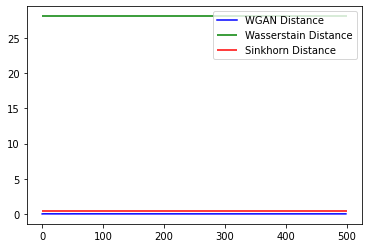

In [139]:
plt.plot(losses[0], label="WGAN Distance", color="blue")
plt.hlines(W1_ground_truth, xmin=0, xmax=len(losses[0]), label="Wasserstain Distance", color="green")
plt.hlines(W1_sinkhorn, xmin=0, xmax=len(losses[0]), label="Sinkhorn Distance", color="red")
plt.legend()
plt.show()